In [84]:
from feature_selection import movie
from feature_selection import scraper_rotten_tomatoes
import os
import pickle
import seaborn as sns
from multiprocessing import Pool
from datetime import datetime
import numpy as np
import operator
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sns.set(color_codes=True)

/Users/chenyuan/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [83]:
movie_dict = movie.get_info_with_localname('Black Panther(2018)')
print(movie_dict['summary']['Genre'])
budget = movie_dict['summary']['Budget']
revenue = movie_dict['international']['Worldwide Box Office'][0]['Revenue']
genre = movie_dict['summary']['Genre']
print(keywords)
# print(news)
ROI = (revenue - budget) / budget
print(ROI)

Action
['Martial Arts', ' Marvel Comics', ' Royalty', ' Magical Technology', ' World War III', ' Civil War', ' Rebellion', ' Ensemble', ' Africa', ' Fictional Country']
5.667347265


In [69]:
def is_released(movie_name, movie_infos):
    if 'Domestic Releases' not in movie_infos[movie_name]['summary']:
        return False
    elif len(movie_infos[movie_name]['summary']['Domestic Releases'].keys()) == 0:
        return False
    else:
        release = movie_infos[movie_name]['summary']['Domestic Releases']
        if 'Wide' in release and release['Wide'] > datetime.now():
            return False
        elif 'IMAX' in release and release['IMAX'] > datetime.now():
            return False
        elif 'Limited' in release and release['Limited'] > datetime.now():
            return False
        else:
            return True

# get the names of all the movie
def get_movie_names_all():
    with open('movie_info.pkl', 'rb') as f:
        movie_infos = pickle.load(f)
    count = 0
    movie_names = list(movie_infos.keys())
    movie_names = [movie_name for movie_name in movie_names if is_released(movie_name, movie_infos)]
    return movie_names

print(get_movie_names_all()[:10])

['Avatar(2009)', 'Pirates of the Caribbean: On Stranger Tides(2011)', 'Avengers: Age of Ultron(2015)', 'Star Wars Ep. VII: The Force Awakens(2015)', 'Pirates of the Caribbean: At World’s End(2007)', 'Justice League(2017)', 'Spectre(2015)', 'The Dark Knight Rises(2012)', 'The Lone Ranger(2013)', 'John Carter(2012)']


In [70]:
# calculate the ROI of a movie
def get_revenue(movie_name, all_dict):
    movie_dict = all_dict[movie_name]
    if len(movie_dict['international']['Worldwide Box Office']) != 0:
        revenue = movie_dict['international']['Worldwide Box Office'][0]['Revenue']
    elif len(movie_dict['international']['International Box Office']) != 0:
        revenue = movie_dict['international']['International Box Office'][0]['Revenue']
    elif len(movie_dict['box_office']['demostic']) != 0:
        revenue = movie_dict['box_office']['demostic'][0]['Revenue']
    else:
        revenue = None
    return revenue

def get_revenues():
    movie_names = get_movie_names_all()
    
    with open('movie_info.pkl', 'rb') as f:
        movie_dict = pickle.load(f)
    
    output = []
    for movie_name in movie_names:
        revenue = get_revenue(movie_name, movie_dict)
        if revenue is not None:
            output.append( (movie_name, revenue) )
    return output
    

def get_ROI(movie_name, all_dict):
    movie_dict = all_dict[movie_name]
    budget = movie_dict['summary']['Budget']
    revenue = get_revenue(movie_name, all_dict)
    if revenue is None:
        return None
    if movie_name == 'Deep Throat(1972)':
        print(revenue, budget)
    ROI = (revenue - budget) / budget
    return ROI

def get_ROIs():
    movie_names = get_movie_names_all()
    print(movie_names[:10])
    
    with open('movie_info.pkl', 'rb') as f:
        movie_dict = pickle.load(f)
    
    output = []
    for movie_name in movie_names:
        ROI = get_ROI(movie_name, movie_dict)
        if ROI is not None:
            output.append( (movie_name, ROI) )
    
    # output.sort(key=operator.itemgetter(1))
    # output.reverse()
    return output

ROIs = get_ROIs()
# print(ROIs[:100])

['Avatar(2009)', 'Pirates of the Caribbean: On Stranger Tides(2011)', 'Avengers: Age of Ultron(2015)', 'Star Wars Ep. VII: The Force Awakens(2015)', 'Pirates of the Caribbean: At World’s End(2007)', 'Justice League(2017)', 'Spectre(2015)', 'The Dark Knight Rises(2012)', 'The Lone Ranger(2013)', 'John Carter(2012)']
45000000 25000


163.582727273
-0.446255463768
[   5.5503976     1.54667286    3.25958476 ...,   39.0825       -0.7324
  163.58272727]


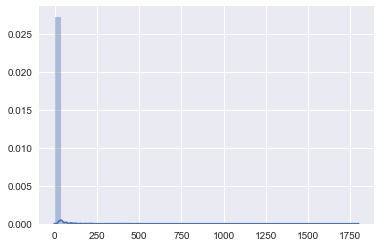

In [71]:
# visualize the ROI distributions
ROI_np = np.array([ROI[1] for ROI in ROIs])
print(ROI_np[-1])
print(ROI_np[200])
print(ROI_np)

sns.distplot(ROI_np[200:])
plt.show()

The individual difference of the ROI of each movie could be very large, ranging from -0.9999749 to 1799. With regard to the movie with exceptionally large ROI, we regard these values as outliers and give special consideration. We divide our ROI range into the following groups: [-0.9999749, 0), [0, 1), [1, 2), [2, 5), [5, 10), [10, 30), [30, ..). Now, we use this boudary to label the different movies.

In [72]:
# categorize the movie using their ROI
def label_roi(roi):
    if roi > -1 and roi < 0:
        return 0
    elif roi >= 0 and roi < 1:
        return 1
    elif roi >= 1 and roi < 2:
        return 2
    elif roi >= 2 and roi < 5:
        return 3
    elif roi >= 3 and roi < 10:
        return 4
    elif roi >= 10 and roi < 30:
        return 5
    else:
        return 6
# label all the movies
def get_labels_roi():
    ROIs = get_ROIs()
    output = []
    for ROI in ROIs:
        roi = ROI[1]
        movie_name = ROI[0]
        label = label_movie(roi)
        output.append((movie_name, label))
    return output

def label_revenue(revenue):
    # pass
    if revenue > 0 and revenue < 1000000:
        return 0
    elif revenue >= 1000000 and revenue < 5000000:
        return 1
    elif revenue >= 5000000 and revenue < 10000000:
        return 2
    elif revenue >= 10000000 and revenue < 50000000:
        return 3
    elif revenue >= 50000000 and revenue < 100000000:
        return 4
    elif revenue >= 100000000 and revenue < 500000000:
        return 5
    elif revenue >= 500000000 and revenue < 1000000000:
        return 6
    else:
        return 7

def get_labels_revenue():
    movie_revenues = get_revenues()
    output = []
    for movie_revenue in movie_revenues:
        movie_name = movie_revenue[0]
        revenue = movie_revenue[1]
        if revenue is None:
            continue
        label = label_revenue(revenue)
        output.append( (movie_name, label) )
    return output
    

In [77]:
# get the distributions of the movies dataset using the ROI

movie_names = get_movie_names_all()
ROIs = get_ROIs()
labels = get_labels_roi()
revenues = get_revenues()
labels_revenue = get_labels_revenue()
statistics_revenue = {}
for i in range(8):
    statistics_revenue[i] = 0
for movie, label in labels_revenue:
    statistics_revenue[label] += 1
print(statistics_revenue)

print(len(revenues), len(ROIs))
print(revenues[:10])
print(ROIs[:10])

# print(revenues[:10])

# find out the number of movies for each ROI category
labels = label_movies()
statistics_roi = {}
for i in range(7):
    statistics_roi[i] = 0
for movie, label in labels:
    statistics_roi[label] += 1
print(statistics)

w, h = 8, 7
Matrix = [[[] for x in range(w)] for y in range(h)]
Matrix_keywords = [[[] for x in range(w)] for y in range(h)]

for i in range(len(revenues)):
    row = labels[i][1]
    col = labels_revenue[i][1]
    Matrix[row][col].append(labels[i][0])
# print(Matrix)




['Avatar(2009)', 'Pirates of the Caribbean: On Stranger Tides(2011)', 'Avengers: Age of Ultron(2015)', 'Star Wars Ep. VII: The Force Awakens(2015)', 'Pirates of the Caribbean: At World’s End(2007)', 'Justice League(2017)', 'Spectre(2015)', 'The Dark Knight Rises(2012)', 'The Lone Ranger(2013)', 'John Carter(2012)']
45000000 25000
['Avatar(2009)', 'Pirates of the Caribbean: On Stranger Tides(2011)', 'Avengers: Age of Ultron(2015)', 'Star Wars Ep. VII: The Force Awakens(2015)', 'Pirates of the Caribbean: At World’s End(2007)', 'Justice League(2017)', 'Spectre(2015)', 'The Dark Knight Rises(2012)', 'The Lone Ranger(2013)', 'John Carter(2012)']
45000000 25000
{0: 580, 1: 464, 2: 363, 3: 1531, 4: 766, 5: 1165, 6: 149, 7: 32}
5050 5050
[('Avatar(2009)', 2783918982), ('Pirates of the Caribbean: On Stranger Tides(2011)', 1045663875), ('Avengers: Age of Ultron(2015)', 1408218722), ('Star Wars Ep. VII: The Force Awakens(2015)', 2058662225), ('Pirates of the Caribbean: At World’s End(2007)', 9634

In [86]:
# get the semantics of a comment
def get_semantics(text):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(text)
    neg = ss['neg']
    neu = ss['neu']
    compound = ss['compound']
    pos = ss['pos']
    print(neg, neu, compound, pos)

print(get_semantics("This is so great! haha"))

0.0 0.254 0.8693 0.746
None


In [ ]:
# get the most frequent keywords for a distribution

# get the genre distribution for each category

# get the 